In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from consumer_resource_OR import ConsumerResourceModel, MergedSolution #, generate_crmodel
from concurrent.futures import ProcessPoolExecutor

# reload module if modified
import importlib
import consumer_resource
importlib.reload(consumer_resource)
from consumer_resource import ConsumerResourceModel, MergedSolution

# Modify this function to change paramter range

In [2]:
def generate_crmodel(nS, nR, seeds, **kwargs):
    """Generate a consumer-resource model with random parameters

    Parameters
    ----------
    nS : int
        Number of species
    nR : int
        Number of resources
    seeds : int or list of int, optional
        Random seed(s) to initialize the random number generator. If not provided, the random number generator will be initialized with the current system time.
    **kwargs : dict, optional. Keyword arguments to replace random parameters. The following keys are allowed:
        v0 : array_like, shape (nS, nR)
            Maximum uptake rate
        km0 : array_like, shape (nS, nR)
            Half-saturation constant
        r0 : array_like, shape (nS,)
            Growth rate
        e : array_like, shape (nS, nR)
            Energy loss coefficient
        b : array_like, shape (nS, nR, nR)
            Competition matrix
        gamma : array_like, shape (nS,)
            Mortality rate

    Returns
    -------
    crmodel : ConsumerResourceModel
        A consumer-resource model with random parameters
    """
    crmodel_list = []

    for seed in seeds:
        # generate random parameters
        np.random.seed(seed)
        v0 = np.random.uniform(1, 1, (nS, nR))
        km0 = np.random.uniform(0, 10, (nS, nR))
        r0 = np.random.uniform(0.2, 0.8, nS)
        e = np.random.uniform(0, 1, (nS, nR))
        b = np.random.uniform(-3, 1, (nS, nR, nR))
        b[b < 0] = 0  # sparse
        b_sum = np.sum(b, axis=2, keepdims=True)
        b = np.where(b_sum > 0, b / b_sum, 0)
        b[:, np.eye(nR, dtype=bool)] = 0  # secresion of same resource is considered as energy lost to the environment
        gamma = np.random.uniform(0, 0, nS)
        paras = {'v0': v0, 'km0': km0, 'r0': r0, 'e': e, 'b': b, 'gamma': gamma}
        
        # process kwargs to replace random parameters
        for key, value in kwargs.items():
            if key in ['v0', 'km0', 'r0', 'e', 'b', 'gamma']:
                paras[key] = value
            else:
                print(f'Warning from generate_crmodel(): {key} is not a valid key. Ignored.')
        crmodel = ConsumerResourceModel(nS, nR, **paras)
        crmodel_list.append(crmodel)

    return crmodel_list

# Demo

/var/folders/_t/bymy836s6gl4slgbzpyqr4900000gn/T/ipykernel_3102/2954433889.py:43: RuntimeWarning: invalid value encountered in divide
  b = np.where(b_sum > 0, b / b_sum, 0)


Text(0.5, 1.0, 'Daily dilution')

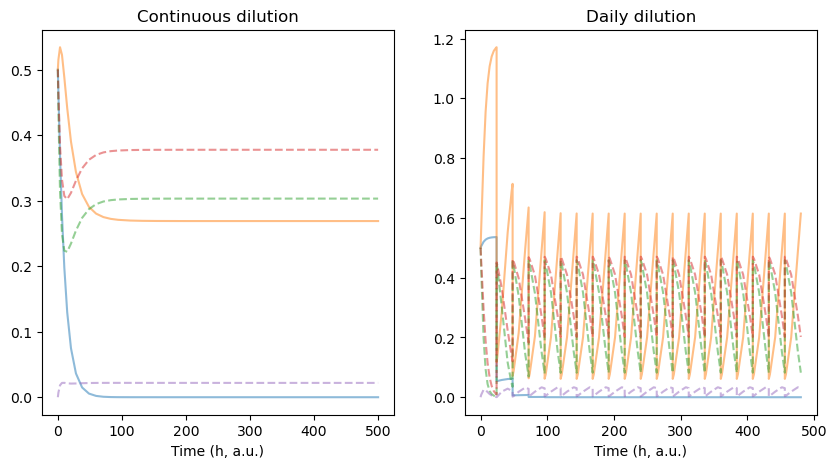

In [3]:

crm = generate_crmodel(2, 3, [0])[0]
N0 = np.array([0.5, 0.5])
R0 = np.array([0.5, 0.5, 0])

dil = 0.1

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# continuous dilution simulation
sol_c = crm.sim([0, 500], N0, R0, dil=dil, Rsupp=R0, nRsupp=1)
plt.sca(axes[0])
plt.plot(sol_c.t, sol_c.y[:crm.nS, :].T, alpha=0.5)
plt.plot(sol_c.t, sol_c.y[crm.nS:, :].T, '--', alpha=0.5)
plt.xlabel('Time (h, a.u.)')
plt.title('Continuous dilution')
# daily dilution simulation
sol_d = crm.sim_daily_dil(20, dil, N0, R0, Rsupp=R0, T=24, nRsupp=1)
plt.sca(axes[1])
plt.plot(sol_d.t, sol_d.y[:crm.nS, :].T, alpha=0.5)
plt.plot(sol_d.t, sol_d.y[crm.nS:, :].T, '--', alpha=0.5)
plt.xlabel('Time (h, a.u.)')
plt.title('Daily dilution')

# Resource diversity vs. species diversity (default) with the same communities, different resources

In [5]:
import numpy as np
import pickle
import pandas as pd
from consumer_resource_OR import ConsumerResourceModel, MergedSolution
from consumer_resource_OR import generate_crmodel  # if not imported, define it here

# Parameters
nS, nR = 50, 100
N_runs = 50  # Number of communities
nRsupp_list = [1, 2, 4, 8, 16, 32, 64]

# Generate 50 random communities
community_list = generate_crmodel(nS, nR, range(N_runs))
N0 = np.ones(nS) / nS  # Initial species abundance

# Prepare a list to store the data
output_data = []

# Loop over each community and then each resource condition
for community_idx, crm in enumerate(community_list, start=1):
    print(f"Community {community_idx}/{N_runs}", end=':')
    for nRsupp in nRsupp_list:
        print('.', end='')
        # Create an R0 vector with zeros and assign 1/nRsupp to randomly selected indices
        R0 = np.zeros(nR)
        selected_indices = np.random.choice(nR, nRsupp, replace=False)
        R0[selected_indices] = 1 / nRsupp
        
        # Run the simulation
        sol = crm.sim([0, 480], N0, R0, dil=0.1, Rsupp=R0, atol=1e-3, nRsupp=nRsupp)
        
        # Extract the last time point's species abundances
        final_abundance = sol.y[:nS, -1]
        
        # Append the results along with the current resource number and community id
        output_data.append(list(final_abundance) + [nRsupp, community_idx])
    print()  # Newline for community progress

# Define column names (strain abundances, number of resource, community id)
column_names = [f'strain{i+1}' for i in range(nS)] + ['number_of_resource', 'community']

# Create a DataFrame and save to CSV
output_df = pd.DataFrame(output_data, columns=column_names)
output_df.to_csv('simulation_results_default_model_same_communities_different_resources.csv', index=False)

print("Data saved to simulation_results_default_model.csv")


Community 1/50:.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


......
Community 2/50:.......
Community 3/50:.......
Community 4/50:.......
Community 5/50:.......
Community 6/50:.......
Community 7/50:.......
Community 8/50:.......
Community 9/50:.......
Community 10/50:.......
Community 11/50:.......
Community 12/50:.......
Community 13/50:.......
Community 14/50:.......
Community 15/50:.......
Community 16/50:.......
Community 17/50:.......
Community 18/50:.......
Community 19/50:.......
Community 20/50:.......
Community 21/50:.......
Community 22/50:.......
Community 23/50:.......
Community 24/50:.......
Community 25/50:.......
Community 26/50:.......
Community 27/50:.......
Community 28/50:.......
Community 29/50:.......
Community 30/50:.......
Community 31/50:.......
Community 32/50:.......
Community 33/50:.......
Community 34/50:.......
Community 35/50:.......
Community 36/50:.......
Community 37/50:.......
Community 38/50:.......
Community 39/50:.......
Community 40/50:.......
Community 41/50:.......
Community 42/50:.......
Community 43/50:.

In [6]:
import numpy as np
import pickle
import pandas as pd

nS, nR = 50, 100
N_runs = 50  # Number of model runs
crm_list = generate_crmodel(nS, nR, range(N_runs))
nRsupp_list = [1, 2, 4, 8, 16, 32, 64]

sol_list = np.zeros((len(crm_list), len(nRsupp_list)), dtype=object)
N0 = np.ones(nS) / nS

# Prepare a list to store the data
output_data = []

for imod, crm in enumerate(crm_list):
    print(f'Model {imod+1}/{len(crm_list)}', end=':')
    for idiv, nRsupp in enumerate(nRsupp_list):
        print('.', end='')
        R0 = np.zeros(nR)
        R0[np.random.choice(nR, nRsupp, replace=False)] = 1 / nRsupp
        
        sol = crm.sim([0, 480], N0, R0, dil=0.1, Rsupp=R0, atol=1e-3, nRsupp=nRsupp)
        sol_list[imod, idiv] = sol
        
        # Extract the last time point data (Ensure only nS values are taken)
        final_abundance = sol.y[:nS, -1]  # Fix: Extract only first nS strains
        
        # Store row data
        output_data.append(list(final_abundance) + [nRsupp, imod+1])
    print()

# Define column names
column_names = [f'strain{i+1}' for i in range(nS)] + ['number_of_resource', 'loop']

# Create DataFrame
output_df = pd.DataFrame(output_data, columns=column_names)

# Save to CSV
output_df.to_csv('simulation_results_default_model.csv', index=False)

print("Data saved to simulation_results.csv")


Model 1/50:.......
Model 2/50:.......
Model 3/50:.......
Model 4/50:.......
Model 5/50:.......
Model 6/50:.......
Model 7/50:.......
Model 8/50:.......
Model 9/50:.......
Model 10/50:.......
Model 11/50:.......
Model 12/50:.......
Model 13/50:.......
Model 14/50:.......
Model 15/50:.......
Model 16/50:.......
Model 17/50:.......
Model 18/50:.......
Model 19/50:.......
Model 20/50:.......
Model 21/50:.......
Model 22/50:.......
Model 23/50:.......
Model 24/50:.......
Model 25/50:.......
Model 26/50:.......
Model 27/50:.......
Model 28/50:.......
Model 29/50:.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


......
Model 30/50:.......
Model 31/50:.......
Model 32/50:.......
Model 33/50:.......
Model 34/50:.......
Model 35/50:.......
Model 36/50:.......
Model 37/50:.......
Model 38/50:.......
Model 39/50:.......
Model 40/50:.......
Model 41/50:.......
Model 42/50:.......
Model 43/50:.......
Model 44/50:.......
Model 45/50:.......
Model 46/50:.......
Model 47/50:.......
Model 48/50:.......
Model 49/50:.......
Model 50/50:.......
Data saved to simulation_results.csv



Results saved to shannon_diversity_vs_resources_default_model.csv


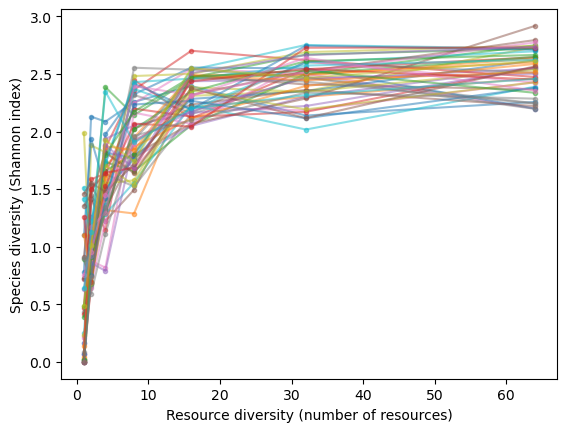

In [6]:
import pandas as pd

# calculate species diversity (Shannon index)
shannon_div_arr = np.zeros((len(crm_list), len(nRsupp_list)))
for imod in range(len(crm_list)):
    for idiv in range(len(nRsupp_list)):
        N = sol_list[imod, idiv].y[:nS, -1]
        N[N < 0] = 0
        N = N / np.sum(N, axis=0, keepdims=True)
        shannon_div_arr[imod, idiv] = -np.sum(N * np.log(N + 1e-10), axis=0)

# plot species diversity vs. resource diversity scatter
plt.figure()
for imod in range(len(crm_list)):
    plt.plot(nRsupp_list, shannon_div_arr[imod, :], '.-', alpha=0.5)
plt.xlabel('Resource diversity (number of resources)')
plt.ylabel('Species diversity (Shannon index)')

# Store results in a list before converting to DataFrame
csv_data = []

for imod in range(len(crm_list)):
    for idiv, nRsupp in enumerate(nRsupp_list):
        shannon_value = shannon_div_arr[imod, idiv]
        csv_data.append([nRsupp, shannon_value, imod + 1])  # `imod + 1` to start from loop 1

# Convert to DataFrame
df = pd.DataFrame(csv_data, columns=["number_of_resources", "shannons_diversity", "loop"])

# Save as CSV
csv_filename = "shannon_diversity_vs_resources_default_model.csv"
df.to_csv(csv_filename, index=False)

print(f"\nResults saved to {csv_filename}")

# Highly and Mildly induced strains - now iterate over different gammas, fraction is fixed

In [16]:
import numpy as np
import pandas as pd

# Model parameters
nS, nR = 50, 100  # Number of species and resources
nRsupp_list = [1, 2, 4, 8, 16, 32, 64]  # Resource diversity levels
gamma_list = np.arange(0, 0.05, 0.002)  # Iterate over gamma from 0 to X in steps of Y


X = 3  # Number of repetitions per gamma

# Store abundance results
abundance_data = []

for gamma in gamma_list:  # Iterate over different gamma values
    print(f"\n==== Processing Gamma {gamma:.4f} ====")

    crm_hacc = generate_crmodel(1000, nR, range(1), gamma=gamma)[0]  # Pool of HACC species
    crm_macc = generate_crmodel(1000, nR, range(1), gamma=0)[0]  # Pool of MACC species

    for x in range(X):  # Repeat `X` times for each gamma
        print('.', end='')

        # Set fraction of HACC to a selected value
        f = 0.9
        n_hacc = int(nS * f)
        n_macc = nS - n_hacc

        # Select subsets of species
        hacc_idx = np.random.choice(1000, n_hacc, replace=False)
        macc_idx = np.random.choice(1000, n_macc, replace=False)

        # Create the model with selected species
        crm_hacc_subset = crm_hacc.subset(hacc_idx)
        crm_macc_subset = crm_macc.subset(macc_idx)
        crm = crm_macc_subset + crm_hacc_subset  # 🔹 Ensures MACC comes first!

        for idiv, nRsupp in enumerate(nRsupp_list):
            # Randomly select `nRsupp` resources to supply
            R0 = np.zeros(nR)
            R0[np.random.choice(nR, nRsupp, replace=False)] = 1 / nRsupp

            # Simulate the model
            sol = crm.sim([0, 480], np.ones(nS) / nS, R0, dil=0.1, Rsupp=R0, atol=1e-3, nRsupp=nRsupp)

            # Extract final species abundances
            abundances = sol.y[:nS, -1]

            # Store results: gamma, loop number, resource diversity, and abundances
            abundance_data.append([gamma, x + 1, nRsupp] + list(abundances))

# Convert results to Pandas DataFrame
column_names = ["gamma", "loop", "number_of_resources"] + \
               [f"MACC_{i+1}" for i in range(n_macc)] + \
               [f"HACC_{i+1}" for i in range(n_hacc)]

df = pd.DataFrame(abundance_data, columns=column_names)

# Save as CSV
csv_filename = "species_abundances_by_gamma_f0.9.csv"
df.to_csv(csv_filename, index=False)
print(f"\nResults saved as {csv_filename}")


==== Processing Gamma 0.0000 ====
.....
==== Processing Gamma 0.0020 ====
.....
==== Processing Gamma 0.0040 ====
.....
==== Processing Gamma 0.0060 ====
.....
==== Processing Gamma 0.0080 ====
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


....
==== Processing Gamma 0.0100 ====
.....
==== Processing Gamma 0.0120 ====
.....
==== Processing Gamma 0.0140 ====
.....
==== Processing Gamma 0.0160 ====
.....
==== Processing Gamma 0.0180 ====
.....
==== Processing Gamma 0.0200 ====
.....
==== Processing Gamma 0.0220 ====
.....
==== Processing Gamma 0.0240 ====
.....
==== Processing Gamma 0.0260 ====
.....
==== Processing Gamma 0.0280 ====
.....
==== Processing Gamma 0.0300 ====
.....
==== Processing Gamma 0.0320 ====
.....
==== Processing Gamma 0.0340 ====
.....
==== Processing Gamma 0.0360 ====
.....
==== Processing Gamma 0.0380 ====
.....
==== Processing Gamma 0.0400 ====
.....
==== Processing Gamma 0.0420 ====
.....
==== Processing Gamma 0.0440 ====
.....
==== Processing Gamma 0.0460 ====
.....
==== Processing Gamma 0.0480 ====
.....
Results saved as species_abundances_by_gamma_f0.9.csv


# HACC, MACC - with defined fractions of HACC and looping over them

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Model parameters
nS, nR = 50, 100
#crm_hacc = generate_crmodel(1000, nR, range(1), gamma=0.04)[0]  # Pool of HACC species
crm_hacc = generate_crmodel(1000, nR, range(1), gamma=0.05)[0]  # Pool of HACC species
crm_macc = generate_crmodel(1000, nR, range(1), gamma=0)[0]    # Pool of MACC species

nRsupp_list = [1, 2, 4, 8, 16, 32, 64]

# Fractions of HACC to test
f_list = np.arange(0, 1.05, 0.05)  # 0, 0.05, 0.1, ..., 1.0
X = 20  # Number of repetitions for each `f`

# For Shannon diversity
shannon_div_all = np.zeros((len(f_list), len(nRsupp_list), X))

# For storing final abundances
abundance_records = []  # We'll append rows here

for ifrac, f in enumerate(f_list):
    print(f"\n==== Processing HACC fraction {f:.2f} ({ifrac+1}/{len(f_list)}) ====")
    
    # Number of HACC and MACC species
    n_hacc = int(nS * f)
    n_macc = nS - n_hacc
    
    for x in range(X):  # Repeat X times
        print('.', end='')
        
        # Randomly select which species become HACC vs. MACC
        hacc_idx = np.random.choice(1000, n_hacc, replace=False)
        macc_idx = np.random.choice(1000, n_macc, replace=False)
        
        # IMPORTANT: Ensure MACC species come first so columns match
        crm_macc_sub = crm_macc.subset(macc_idx)
        crm_hacc_sub = crm_hacc.subset(hacc_idx)
        
        # Concatenate MACC first, HACC second
        crm = crm_macc_sub + crm_hacc_sub
        
        # Prepare to simulate across multiple resource diversities
        sol_list = np.zeros(len(nRsupp_list), dtype=object)
        N0 = np.ones(nS) / nS
        
        for idiv, nRsupp in enumerate(nRsupp_list):
            # Build resource supply vector
            R0 = np.zeros(nR)
            R0[np.random.choice(nR, nRsupp, replace=False)] = 1 / nRsupp
            
            # Simulate model
            sol = crm.sim([0, 480], N0, R0, dil=0.1, Rsupp=R0, atol=1e-3, nRsupp=nRsupp)
            sol_list[idiv] = sol
            
            # Extract final species abundances
            final_abund = sol.y[:nS, -1]  # shape (nS,)
            final_abund[final_abund < 0] = 0.0  # remove negatives
            total_biomass = np.sum(final_abund)
            
            # Avoid division by zero
            if total_biomass > 0:
                rel_abund = final_abund / total_biomass
            else:
                rel_abund = final_abund  # all zeros
            
            # Store Shannon
            shannon_div_all[ifrac, idiv, x] = -np.sum(rel_abund * np.log(rel_abund + 1e-10))
            
            # We only want to store the final relative abundances ONCE per run
            # or for each nRsupp? If for each nRsupp, add below:
            # for each nRsupp, we store abundances
            # We'll store them for each nRsupp, too:
            row = list(rel_abund)  # MACC first, then HACC
            row.append(f)          # fraction_of_HACC
            row.append(x + 1)      # loop index
            row.append(nRsupp)     # number_of_resources
            abundance_records.append(row)
    print()

# -------------- Save Shannon Diversity (Optional) --------------
# (If you still want to store mean + std or a separate CSV)

# -------------- Create a DataFrame for the final abundances --------------
# Column names: MACC_1..MACC_n, HACC_1..HACC_n, fraction_of_HACC, loop, number_of_resources
macc_cols = [f"MACC_{i+1}" for i in range(n_macc)]  # Final run's n_macc
hacc_cols = [f"HACC_{i+1}" for i in range(n_hacc)]

# But note: each f might have different n_macc, n_hacc. We'll unify by max possible nS=50
# So let's do the maximum possible scenario to name columns consistently:
max_macc = nS  # if f=0
max_hacc = nS  # if f=1

# We'll handle up to 50 columns for MACC, 50 for HACC
# In rows with fewer MACC or HACC, extras remain 0 or unused
all_macc_cols = [f"MACC_{i+1}" for i in range(max_macc)]
all_hacc_cols = [f"HACC_{i+1}" for i in range(max_hacc)]

# We need to unify abundance_records so we can place them in a DataFrame consistently.
# We'll do a final step: each row has len= nS + 3 => we might pad with zeros if needed
# But let's assume each row is EXACTLY nS + 3

columns = all_macc_cols + all_hacc_cols + ["fraction_of_HACC", "loop", "number_of_resources"]

# Convert abundance_records to padded format
padded_records = []
for row in abundance_records:
    # row = [ rel_abund_of_50_species, fraction_of_HACC, loop, nRsupp ]
    # But if f < 1, we have M < 50 for MACC, H < 50 for HACC
    # We'll place them in the front if M < 50, we fill the rest with 0
    # Actually easier approach:
    # row[:nS] are the 50 species
    species_abund = row[:nS]  
    f_value = row[nS]
    loop_value = row[nS+1]
    nrsupp_value = row[nS+2]
    
    # We know we labeled MACC first, then HACC => species_abund[0..macc-1], species_abund[macc..macc+hacc-1]
    # But we want them in a single 50 + 50 pad
    # Actually let's parse them:
    # If there's n_macc = 25, n_hacc=25 for a specific row => the first 25 are MACC, next 25 are HACC
    # Then we pad rest with zeros.
    
    # But we don't know n_macc for the row.  We'll infer from sum of species_abund > 0? 
    # We do know f_value => n_hacc = int(nS*f_value)
    # Actually f_value might not be EXACT if fraction was 0.05 => 2.5 => 2 species
    # We'll do:
    current_n_hacc = int(nS * f_value + 0.5)  # round
    current_n_macc = nS - current_n_hacc
    
    # Extract MACC part
    macc_part = species_abund[:current_n_macc]
    hacc_part = species_abund[current_n_macc:current_n_macc + current_n_hacc]
    
    # Pad them up to max_macc and max_hacc
    padded_macc = list(macc_part) + [0]*(max_macc - current_n_macc)
    padded_hacc = list(hacc_part) + [0]*(max_hacc - current_n_hacc)
    
    new_row = padded_macc + padded_hacc + [f_value, loop_value, nrsupp_value]
    padded_records.append(new_row)

# Build DataFrame
df_abund = pd.DataFrame(padded_records, columns=columns)

# Save the DataFrame
csv_filename = "final_abundances_MACC_HACC_gamma_0.05.csv"
df_abund.to_csv(csv_filename, index=False)
print(f"Saved final abundances to {csv_filename}")

# -------------- Plot or Do Other Analysis --------------
# e.g. Plot the mean Shannon as function of nRsupp, etc. if desired.


==== Processing HACC fraction 0.00 (1/21) ====
......

==== Processing HACC fraction 0.05 (2/21) ====
..

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


....

==== Processing HACC fraction 0.10 (3/21) ====
......

==== Processing HACC fraction 0.15 (4/21) ====
......

==== Processing HACC fraction 0.20 (5/21) ====
......

==== Processing HACC fraction 0.25 (6/21) ====
......

==== Processing HACC fraction 0.30 (7/21) ====
......

==== Processing HACC fraction 0.35 (8/21) ====
......

==== Processing HACC fraction 0.40 (9/21) ====
......

==== Processing HACC fraction 0.45 (10/21) ====
......

==== Processing HACC fraction 0.50 (11/21) ====
......

==== Processing HACC fraction 0.55 (12/21) ====
......

==== Processing HACC fraction 0.60 (13/21) ====
......

==== Processing HACC fraction 0.65 (14/21) ====
......

==== Processing HACC fraction 0.70 (15/21) ====
......

==== Processing HACC fraction 0.75 (16/21) ====
......

==== Processing HACC fraction 0.80 (17/21) ====
......

==== Processing HACC fraction 0.85 (18/21) ====
......

==== Processing HACC fraction 0.90 (19/21) ====
......

==== Processing HACC fraction 0.95 (20/21) ====
.

Plot saved as shannon_diversity_plot_gamma_0.05.pdf


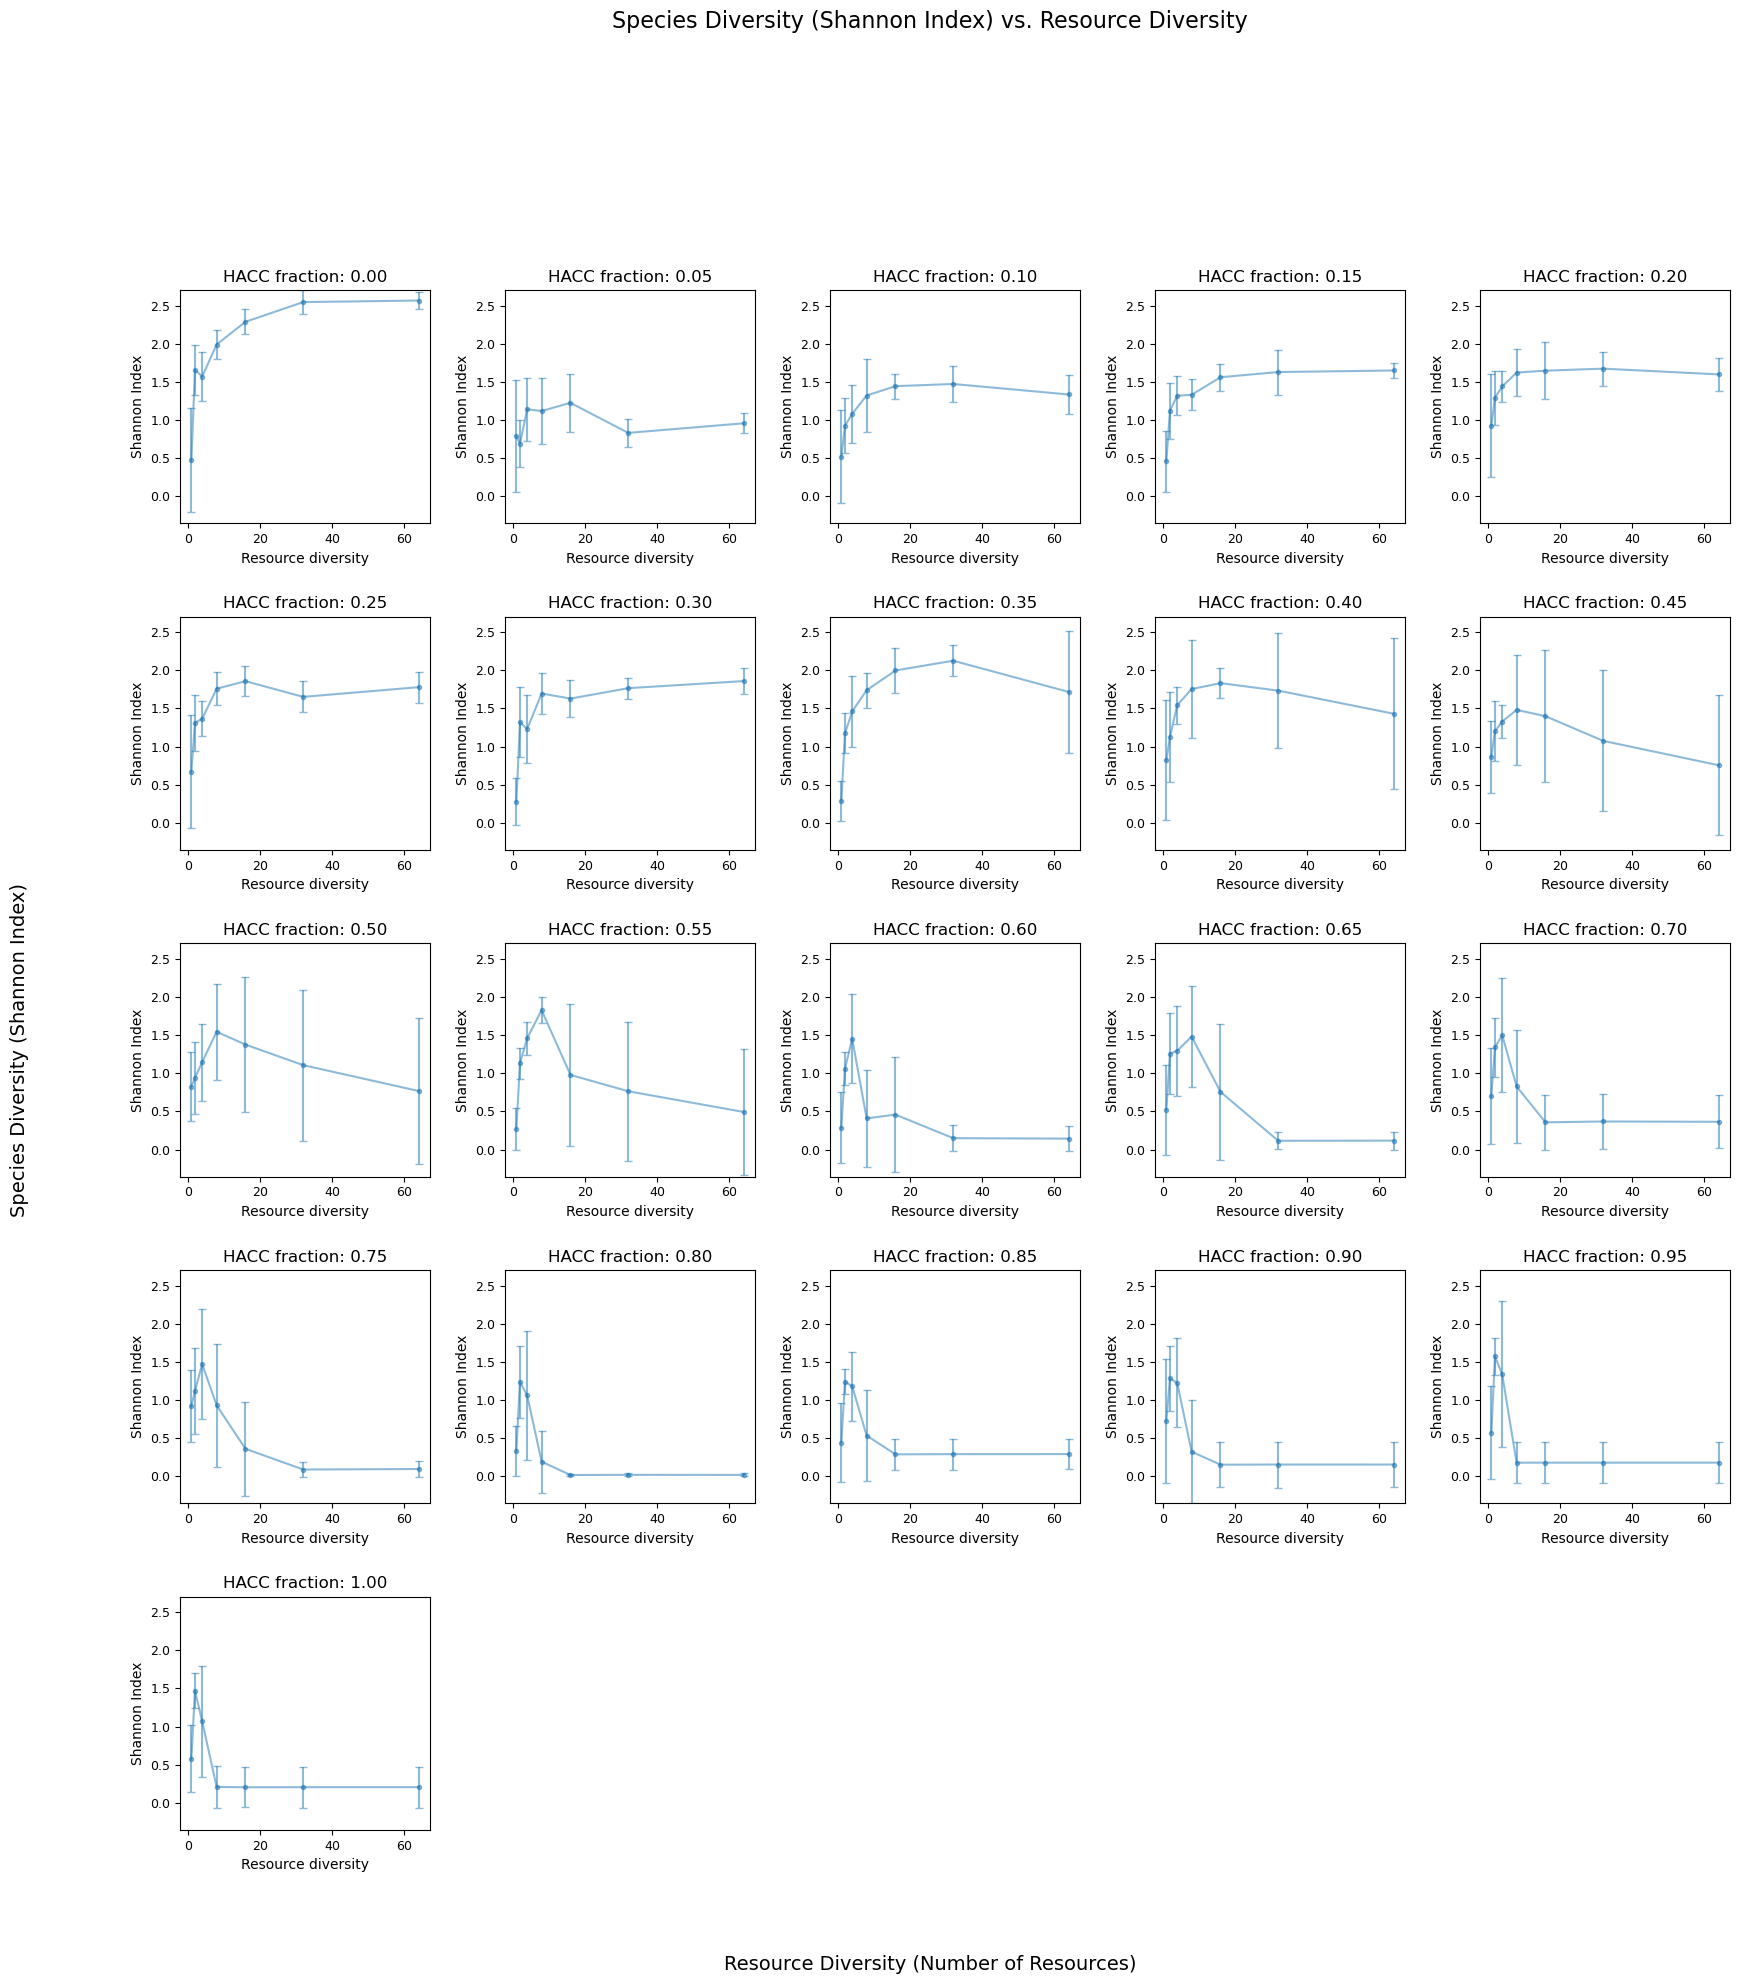

Results saved as shannon_diversity_results_long_gamma_0.05.csv


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Compute Mean and Standard Deviation Across `X` Runs
shannon_div_mean = np.mean(shannon_div_all, axis=2)
shannon_div_std = np.std(shannon_div_all, axis=2)

# 🔹 Find global min and max for consistent Y-axis scaling
y_min = np.min(shannon_div_mean - shannon_div_std)
y_max = np.max(shannon_div_mean + shannon_div_std)

# 🔹 Dynamically set subplot grid based on `f_list` size
n_rows = int(np.ceil(len(f_list) / 5))  # Adjust rows dynamically
fig, axes = plt.subplots(n_rows, 5, figsize=(20, 4 * n_rows))  # Auto-adjust figure size

axes = axes.flatten()  # Flatten to easily access subplots

for ifrac, f in enumerate(f_list):  # Unpack f and plot
    ax = axes[ifrac]  # Select the subplot
    ax.errorbar(nRsupp_list, shannon_div_mean[ifrac, :], yerr=shannon_div_std[ifrac, :], fmt='.-', alpha=0.5, capsize=3)
    ax.set_title(f'HACC fraction: {f:.2f}', fontsize=12)  # Increase title size
    ax.set_ylim(y_min, y_max)  # 🔹 Set same Y-axis scale for all plots
    ax.set_xlabel("Resource diversity", fontsize=10)  # Ensure X-label is visible
    ax.set_ylabel("Shannon Index", fontsize=10)  # Ensure Y-label is visible
    ax.tick_params(axis='both', labelsize=9)  # Reduce tick label size for readability

# 🔹 Hide any unused subplots
for i in range(len(f_list), len(axes)):  
    fig.delaxes(axes[i])

# 🔹 Adjust spacing between subplots to prevent overlap
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Increase spacing between rows (hspace) and columns (wspace)

# 🔹 Set global figure title and labels with more padding
fig.suptitle('Species Diversity (Shannon Index) vs. Resource Diversity', fontsize=16, y=1.02)  # Global title
fig.text(0.5, 0.04, 'Resource Diversity (Number of Resources)', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Species Diversity (Shannon Index)', va='center', rotation='vertical', fontsize=14)

# 🔹 Save the Plot as PNG
plot_filename = "shannon_diversity_plot_gamma_0.05.pdf"
fig.savefig(plot_filename)  # Save with high quality
print(f"Plot saved as {plot_filename}")

plt.show()

# 🔹 Save All Shannon Diversity Data in Long Format CSV
csv_filename = "shannon_diversity_results_long_gamma_0.05.csv"
shannon_data = []

for ifrac, f in enumerate(f_list):  # Loop through all fractions of HACC
    for idiv, nRsupp in enumerate(nRsupp_list):  # Loop through resource numbers
        for x in range(X):  # Loop through all runs
            shannon_data.append([nRsupp, x + 1, f, shannon_div_all[ifrac, idiv, x]])

# Convert to Pandas DataFrame
df = pd.DataFrame(shannon_data, columns=["number_of_resources", "loop", "fraction_of_HACC", "Shannons_diversity"])
df.to_csv(csv_filename, index=False)  # Save CSV without index
print(f"Results saved as {csv_filename}")

# Highly and Mildly induced strains - with defined fractions of HACC and looping over them with various sigmas

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ============ MANUAL LIST OF GAMMA VALUES ============
#gamma_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]  # Custom values of gamma to loop through
gamma_list = np.arange(0, 0.1, 0.005)  # Iterate over gamma from 0 to X in steps of Y


# ============ MODEL PARAMETERS ============
nS, nR = 50, 100
nRsupp_list = [1, 2, 4, 8, 16, 32, 64]
f_list = np.arange(0, 1.05, 0.05)  # HACC fractions (0, 0.05, ..., 1.0)
X = 20  # Number of repetitions per gamma and fraction
nday = 100  # Number of days in the simulation
T = 24  # Hours per day

# ======= LOOP OVER GAMMA VALUES =======
for gamma in gamma_list:
    print(f"\n==== Running simulations for gamma = {gamma:.2f} ====")

    # Generate models for current gamma
    crm_hacc = generate_crmodel(1000, nR, range(1), gamma=gamma)[0]  # Pool of HACC species
    crm_macc = generate_crmodel(1000, nR, range(1), gamma=0)[0]      # Pool of MACC species

    # Store results
    abundance_records = []  # Final abundance data
    shannon_div_all = np.zeros((len(f_list), len(nRsupp_list), X))  # Shannon diversity

    # ======= LOOP OVER HACC FRACTIONS =======
    for ifrac, f in enumerate(f_list):
        print(f"\nProcessing HACC fraction {f:.2f} ({ifrac+1}/{len(f_list)})")

        n_hacc = int(nS * f)
        n_macc = nS - n_hacc

        for x in range(X):  # Repeat X times
            print('.', end='')

            # Randomly assign MACC and HACC species
            hacc_idx = np.random.choice(1000, n_hacc, replace=False)
            macc_idx = np.random.choice(1000, n_macc, replace=False)

            # Ensure MACC species are first
            crm_macc_sub = crm_macc.subset(macc_idx)
            crm_hacc_sub = crm_hacc.subset(hacc_idx)
            crm = crm_macc_sub + crm_hacc_sub

            # Prepare simulations for different resource diversities
            sol_list = np.zeros(len(nRsupp_list), dtype=object)
            N0 = np.ones(nS) / nS

            for idiv, nRsupp in enumerate(nRsupp_list):
                # Build resource supply vector
                R0 = np.zeros(nR)
                R0[np.random.choice(nR, nRsupp, replace=False)] = 1 / nRsupp

                # Simulate model
                sol = crm.sim_daily_dil(nday, dil=0.05, N0=np.ones(nS) / nS, R0=R0, Rsupp=R0, T=T, atol=1e-3, nRsupp=nRsupp)

                #sol = crm.sim([0, 480], N0, R0, dil=0.1, Rsupp=R0, atol=1e-3, nRsupp=nRsupp)
                sol_list[idiv] = sol

                # Extract final species abundances
                final_abund = sol.y[:nS, -1]
                final_abund[final_abund < 0] = 0.0  # Remove negatives
                total_biomass = np.sum(final_abund)

                # Compute relative abundances
                rel_abund = final_abund / total_biomass if total_biomass > 0 else final_abund

                # Store Shannon diversity
                shannon_div_all[ifrac, idiv, x] = -np.sum(rel_abund * np.log(rel_abund + 1e-10))

                # Store abundances for CSV output
                row = list(rel_abund) + [f, x + 1, nRsupp]
                abundance_records.append(row)

        print()

    # ========== Save Final Abundance Data for Current Gamma ==========
    macc_cols = [f"MACC_{i+1}" for i in range(n_macc)]
    hacc_cols = [f"HACC_{i+1}" for i in range(n_hacc)]
    max_macc = nS
    max_hacc = nS

    all_macc_cols = [f"MACC_{i+1}" for i in range(max_macc)]
    all_hacc_cols = [f"HACC_{i+1}" for i in range(max_hacc)]
    columns = all_macc_cols + all_hacc_cols + ["fraction_of_HACC", "loop", "number_of_resources"]

    # Format data for consistent CSV output
    padded_records = []
    for row in abundance_records:
        species_abund = row[:nS]
        f_value, loop_value, nrsupp_value = row[nS:]

        current_n_hacc = int(nS * f_value + 0.5)
        current_n_macc = nS - current_n_hacc

        macc_part = species_abund[:current_n_macc]
        hacc_part = species_abund[current_n_macc:current_n_macc + current_n_hacc]

        padded_macc = list(macc_part) + [0] * (max_macc - current_n_macc)
        padded_hacc = list(hacc_part) + [0] * (max_hacc - current_n_hacc)

        new_row = padded_macc + padded_hacc + [f_value, loop_value, nrsupp_value]
        padded_records.append(new_row)

    # Create DataFrame and save
    df_abund = pd.DataFrame(padded_records, columns=columns)
    csv_filename = f"final_abundances_MACC_HACC_gamma_daily_dilution{gamma:.2f}.csv"
    df_abund.to_csv(csv_filename, index=False)
    print(f"Saved final abundances to {csv_filename}")



==== Running simulations for gamma = 0.00 ====

Processing HACC fraction 0.00 (1/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
....................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
....................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
....................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
....................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
....................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
....................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:153: RuntimeWarning: invalid value encountered in multiply
  secretion = np.sum(np.sum(self.b * ((1 - self.e) * v * N)[:, :, None], axis=0), axis=0, keepdims=True) # nR * 1. sum ov

........
Saved final abundances to final_abundances_MACC_HACC_gamma_daily_dilution0.03.csv

==== Running simulations for gamma = 0.03 ====

Processing HACC fraction 0.00 (1/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
....................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:153: RuntimeWarning: invalid value encountered in multiply
  secretion = np.sum(np.sum(self.b * ((1 - self.e) * v * N)[:, :, None], axis=0), axis=0, keepdims=True) # nR * 1. sum ov

...................

Processing HACC fraction 1.00 (21/21)
....................
Saved final abundances to final_abundances_MACC_HACC_gamma_daily_dilution0.03.csv

==== Running simulations for gamma = 0.04 ====

Processing HACC fraction 0.00 (1/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
....................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
..

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:153: RuntimeWarning: invalid value encountered in multiply
  secretion = np.sum(np.sum(self.b * ((1 - self.e) * v * N)[:, :, None], axis=0), axis=0, keepdims=True) # nR * 1. sum ov

..................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0.90 (19/21)
....................

Processing HACC fraction 0.95 (20/21)
....................

Processing HACC fraction 1.00 (21/21)
....................
Saved final abundances to final_abundances_MACC_HACC_gamma_daily_dilution0.04.csv

==== Running simulations for gamma = 0.04 ====

Processing HACC fraction 0.00 (1/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
....................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
.............

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:154: RuntimeWarning: invalid value encountered in multiply
  dRdt = -uptake + secretion - dil * R + dil * Rsupp


.......

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
..

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:153: RuntimeWarning: invalid value encountered in multiply
  secretion = np.sum(np.sum(self.b * ((1 - self.e) * v * N)[:, :, None], axis=0), axis=0, keepdims=True) # nR * 1. sum over spe then res


..................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0.90 (19/21)
....................

Processing HACC fraction 0.95 (20/21)
....................

Processing HACC fraction 1.00 (21/21)
....................
Saved final abundances to final_abundances_MACC_HACC_gamma_daily_dilution0.04.csv

==== Running simulations for gamma = 0.04 ====

Processing HACC fraction 0.00 (1/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
....................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
.......

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:154: RuntimeWarning: invalid value encountered in multiply
  dRdt = -uptake + secretion - dil * R + dil * Rsupp


.............

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
..

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:153: RuntimeWarning: invalid value encountered in multiply
  secretion = np.sum(np.sum(self.b * ((1 - self.e) * v * N)[:, :, None], axis=0), axis=0, keepdims=True) # nR * 1. sum over spe then res


..................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0.90 (19/21)
....................

Processing HACC fraction 0.95 (20/21)
....................

Processing HACC fraction 1.00 (21/21)
....................
Saved final abundances to final_abundances_MACC_HACC_gamma_daily_dilution0.04.csv

==== Running simulations for gamma = 0.05 ====

Processing HACC fraction 0.00 (1/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:154: RuntimeWarning: invalid value encountered in multiply
  dRdt = -uptake + secretion - dil * R + dil * Rsupp


...................

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:153: RuntimeWarning: invalid value encountered in multiply
  secretion = np.sum(np.sum(self.b * ((1 - self.e) * v * N)[:, :, None], axis=0), axis=0, keepdims=True) # nR * 1. sum over spe then res




Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0.90 (19/21)
.......

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:154: RuntimeWarning: invalid value encountered in multiply
  dRdt = -uptake + secretion - dil * R + dil * Rsupp
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interaction

...................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:154: RuntimeWarning: invalid value encountered in multiply
  dRdt = -uptake + secretion - dil * R + dil * Rsupp
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interaction

...................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:154: RuntimeWarning: invalid value encountered in multiply
  dRdt = -uptake + secretion - dil * R + dil * Rsupp
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interaction

...................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:153: RuntimeWarning: invalid value encountered in multiply
  secretion = np.sum(np.sum(self.b * ((1 - self.e) * v * N)[:, :, None], axis=0), axis=0, keepdims=True) # nR * 1. sum ov

...................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:154: RuntimeWarning: invalid value encountered in multiply
  dRdt = -uptake + secretion - dil * R + dil * Rsupp
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interaction

...................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:154: RuntimeWarning: invalid value encountered in multiply
  dRdt = -uptake + secretion - dil * R + dil * Rsupp
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interaction

...................

Processing HACC fraction 0.10 (3/21)
....

/Users/oshalev/mambaforge/envs/jupyter/lib/python3.10/site-packages/scipy/integrate/_ivp/rk.py:64: RuntimeWarning: overflow encountered in add
  K[s] = fun(t + c * h, y + dy)


................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0.90 (19/21)
....................

Processing HACC fraction 0.9

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:154: RuntimeWarning: invalid value encountered in multiply
  dRdt = -uptake + secretion - dil * R + dil * Rsupp
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interaction

...

/Users/oshalev/mambaforge/envs/jupyter/lib/python3.10/site-packages/scipy/integrate/_ivp/rk.py:64: RuntimeWarning: overflow encountered in add
  K[s] = fun(t + c * h, y + dy)


................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0.90

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:154: RuntimeWarning: invalid value encountered in multiply
  dRdt = -uptake + secretion - dil * R + dil * Rsupp
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interaction

...................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:151: RuntimeWarning: invalid value encountered in divide
  c = v * r / a  # nS * nR, consumption


...................

Processing HACC fraction 0.05 (2/21)
.

/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:145: RuntimeWarning: invalid value encountered in divide
  v = self.v0 * R / (km + R)  # nS * nR
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:154: RuntimeWarning: invalid value encountered in multiply
  dRdt = -uptake + secretion - dil * R + dil * Rsupp
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interactions_by_condition/Experiments/Experiments/Final_in_vitro_experiments/Communities_exp/20250116_simulations_of_communities_RC/consumer_resource_OR.py:150: RuntimeWarning: invalid value encountered in multiply
  dNdt = r * N - dil * N
/Users/oshalev/post-doc/Projects/Genomics_of_suppressive_interaction

...................

Processing HACC fraction 0.10 (3/21)
....................

Processing HACC fraction 0.15 (4/21)
....................

Processing HACC fraction 0.20 (5/21)
....................

Processing HACC fraction 0.25 (6/21)
....................

Processing HACC fraction 0.30 (7/21)
....................

Processing HACC fraction 0.35 (8/21)
....................

Processing HACC fraction 0.40 (9/21)
....................

Processing HACC fraction 0.45 (10/21)
....................

Processing HACC fraction 0.50 (11/21)
....................

Processing HACC fraction 0.55 (12/21)
....................

Processing HACC fraction 0.60 (13/21)
....................

Processing HACC fraction 0.65 (14/21)
....................

Processing HACC fraction 0.70 (15/21)
....................

Processing HACC fraction 0.75 (16/21)
....................

Processing HACC fraction 0.80 (17/21)
....................

Processing HACC fraction 0.85 (18/21)
....................

Processing HACC fraction 0